README: updated: 
- reorganize time_property_modeling.ipynb into fundtion

In [67]:
import os
os.chdir('/Users/liyuan/desktop/SI699/codes')
import pandas as pd
import numpy as np
import time
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

from ts_modeling_v2 import TsModeling
from reformat_data_by_day import Reformat_data
from time_feature_modeling import TimeFeatureModeling
from help import sample_data, get_rmse, get_predictions,extract_time_features

import xgboost as xgb
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA

from prop_modeling_v3 import PropModeling

In [3]:
def get_rmse(pred, true):
    mse = mean_squared_error(true, pred)
    rmse = np.sqrt(mse)
    return rmse

In [4]:
def load_data():
    # load all data
    train = pd.read_csv('../expedia_data/train.csv')
    test = pd.read_csv('../expedia_data/test.csv')
    cols_train_only = [col for col in train.columns.unique().tolist() if col not in test.columns.unique().tolist()]
    train = train.drop(columns = cols_train_only)
    all_data = pd.concat([train, test], ignore_index=True)
    print('there are %d records in train and test data combined' % len(all_data))
    return all_data

all_data = load_data()

there are 16540159 records in train and test data combined


property has 1635 records
property has 242 records by day


/Users/liyuan/Desktop/SI699/codes/ts_modeling_v2.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  prop_data['date_time'] = pd.to_datetime(prop_data.date_time)
/Users/liyuan/Desktop/SI699/codes/ts_modeling_v2.py:77: FutureWarning: 'pandas.tools.plotting.autocorrelation_plot' is deprecated, import 'pandas.plotting.autocorrelation_plot' instead.
  autocorrelation_plot(data)


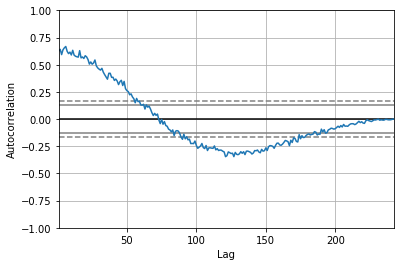

training size: 155
validation size: 38
test size: 48
plot for ARIMA model ...
training size: 155
validation size: 38
test size: 48


/anaconda3/envs/leetcode/lib/python3.6/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/anaconda3/envs/leetcode/lib/python3.6/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
/anaconda3/envs/leetcode/lib/python3.6/site-packages/scipy/signal/signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this 

RMSE: 30.567


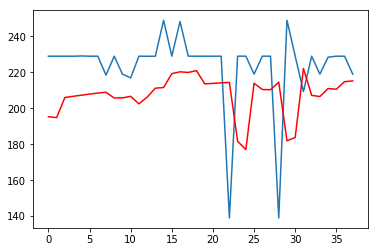

RMSE: 29.306


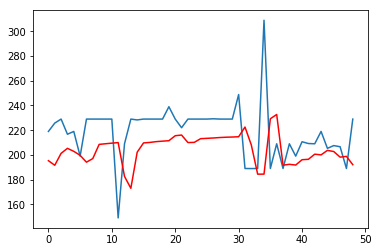

/Users/liyuan/Desktop/SI699/codes/time_feature_modeling.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  price_data['day'] = price_data['date_time'].apply(lambda x: x.day)
/Users/liyuan/Desktop/SI699/codes/time_feature_modeling.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  price_data['week'] = price_data['date_time'].apply(lambda x: x.week)
/Users/liyuan/Desktop/SI699/codes/time_feature_modeling.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexe

price data len: 242
242
variance of data: 2146
training size: 155
validation size: 38
test size: 48
training RMSE: 37.643942427158926
valiation RMSE: 83.92821961729362
test RMSE: 53.46784285103863
(38, 1)
(49, 1)
(38, 1)
(49, 1)
y_train shape: (38, 1)
y_test shape: (49, 1)
train rmse: 22
test rmse: 27


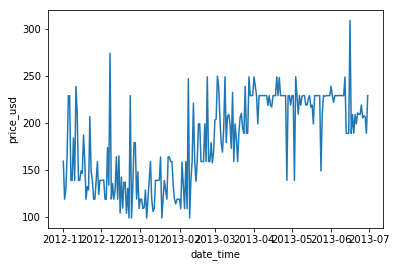

In [49]:
# -------------
# time modeling 
# -------------
def time_modeling(all_data, prop_id):
    '''fit model for time feature'''
    prop_data = all_data[all_data['prop_id'] == prop_id]
    print('property has %d records' % len(prop_data))
    
    tsm = TsModeling()
    prop_data = tsm.process_data_by_prop(prop_data)
    daily_price = prop_data[['price_usd']].resample('D').median()
    print('property has %d records by day'% len(daily_price))
    
    # fit ARIMA
    tsm.get_auto_correlation(daily_price)
    train, val, test = tsm.split_data(daily_price) # split X
    print('plot for ARIMA model ...')
    val_predictions, test_predictions = tsm.fit_ARIMA_model(daily_price.dropna(), 2,0,0)
    
    # fit regression
    daily_price = extract_time_features(daily_price)
    regression_y_pred_train, regression_y_pred_val, regression_y_pred_test = tsm.fit_regression_model(daily_price.dropna())
    
    # task: second-layer modeling (XGBoost)
    # has finished basic parameter tuning
    model = xgb.XGBRegressor(learning_rate = 0.1, max_depth = 5, reg_alpha = 20, n_estimators = 25) 
    y_pred_train_ts, y_pred_test_ts = tsm.second_layer_modeling(model)
    return y_pred_train_ts, y_pred_test_ts


In [57]:
# -----------------
# Property modeling
# -----------------
# below copied from prop_modeling_Crystal_v4.ipynb

# Put this when it's called
from sklearn.model_selection import learning_curve
from sklearn.model_selection import validation_curve
from sklearn.model_selection import cross_val_score

from sklearn import tree
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import ElasticNet

class modeling_pipeline():
    def __init__(self,data,model,variables):
        self.data = data.iloc[:]
        self.train_data = pd.DataFrame()
        self.val_data = pd.DataFrame()
        self.test_data = pd.DataFrame()
        self.model = model
        self.variables = variables
        self.X_train = pd.DataFrame()
        self.X_test = pd.DataFrame()
        self.X_val = pd.DataFrame()
        self.y_train = pd.DataFrame()
        self.y_test = pd.DataFrame()
        self.y_val = pd.DataFrame()

        self.categorical_vars = ['srch_id','site_id','visitor_location_country_id','visitor_hist_starrating','prop_country_id','prop_id',
        'srch_destination_id']

        self.categorical_binary_vars = []
        self.continuous_vars = []

        self.X_train_normalized = pd.DataFrame()
        self.X_val_normalized = pd.DataFrame()
        self.X_test_normalized = pd.DataFrame()

        self.X_train_standardized = pd.DataFrame()
        self.X_val_standardized = pd.DataFrame()
        self.X_test_standardized = pd.DataFrame()
 
    def split_data(self):
        training_size_large = int(len(self.data) * 0.8)   
        validation_size = int(training_size_large * 0.2)
        training_size = training_size_large - validation_size
        test_size = int(len(self.data) * 0.2)
        print('training size: %d'%training_size)
        print('validation size: %d'%validation_size)
        print('test size: %d'%test_size)
        # split data by temporal order
        self.train_data = self.data.iloc[0: training_size]
        self.val_data = self.data.iloc[training_size:(training_size + validation_size)]
        # self.test_data = self.data.iloc[(training_size + validation_size): (training_size + validation_size + test_size)]
        self.test_data = self.data.iloc[(training_size + validation_size):]
        return self.train_data, self.val_data, self.test_data
    
    def divide_variables(self):
        # divide variables into categories
        # get categorical variables
        other_cols = [col for col in self.variables if col not in self.categorical_vars]
        # get categorical binary variables
        self.categorical_binary_vars += ['promotion_flag']
        self.categorical_binary_vars += [col for col in self.data if col.startswith('new')]
        self.categorical_binary_vars += [col for col in self.data if col.endswith('inv')]
        self.categorical_binary_vars += [col for col in self.data if col.endswith('bool')]
        # get continous variables
        self.continuous_vars += [ col for col in self.variables if (col not in self.categorical_binary_vars) & (col not in self.categorical_vars )]
        print ("categorical binary vars: ", len(self.categorical_binary_vars))
        print ("categorical non binary vars: ", len(self.categorical_vars))
        print ("continues vars: ", len(self.continuous_vars))
        return self.categorical_vars, self.categorical_binary_vars, self.continuous_vars

    def get_X_y(self):
        # TODO: need to handle 'date_time' properly
        # for now, leave out "date_time" from modeling
        # self.variables += [col for col in self.data.columns.unique().tolist() if col not in ['price_usd','date_time']]
        self.X_train = self.train_data[self.variables]
        self.y_train = self.train_data['price_usd']
        self.X_val = self.val_data[self.variables]
        self.y_val = self.val_data['price_usd']
        self.X_test = self.test_data[self.variables]
        self.y_test = self.test_data['price_usd']
        return self.X_train, self.y_train, self.X_val, self.y_val, self.X_test, self.y_test

    def get_normalized_X_y(self):
        normalizer = Normalizer().fit(self.X_train) 
        self.X_train_normalized = normalizer.transform(self.X_train)
        self.X_val_normalized = normalizer.transform(self.X_val)
        self.X_test_normalized = normalizer.transform(self.X_test)
        return self.X_train_normalized, self.X_val_normalized, self.X_test_normalized
    
    def get_standardized_X_y(self):
        # usign min-max scaler to standardized
        scaler = MinMaxScaler().fit(self.X_train)
        self.X_train_standardized = scaler.transform(self.X_train)
        self.X_val_standardized = scaler.transform(self.X_val)
        return self.X_train_standardized, self.X_val_standardized, self.X_test_standardized 

    def get_RMSE(self,y_pred,y_true,data):
        return np.sqrt(sum((y_pred - y_true)**2)/len(data))
    
    # updated: adding y_pred_test and test_RMSE
    def get_modeling_result(self):
        reg = self.model.fit(self.X_train, self.y_train)
        y_pred_val = reg.predict(self.X_val)
        y_pred_train = reg.predict(self.X_train)
        y_pred_test = reg.predict(self.X_test)
        val_RMSE = self.get_RMSE(y_pred_val, self.y_val, self.val_data)
        train_RMSE = self.get_RMSE(y_pred_train ,self.y_train, self.train_data)
        test_RMSE = self.get_RMSE(y_pred_test ,self.y_test, self.test_data)
        print('training RMSE:',train_RMSE)
        print('valiation RMSE:',val_RMSE)
        print('test RMSE:',test_RMSE)
        return y_pred_train, y_pred_val, y_pred_test

    def get_normalized_modeling_result(self):
        reg = self.model.fit(self.X_train_normalized, self.y_train)
        y_pred_val = reg.predict(self.X_val_normalized)
        y_pred_train = reg.predict(self.X_train_normalized)
        val_RMSE = self.get_RMSE(y_pred_val, self.y_val, self.val_data)
        train_RMSE = self.get_RMSE(y_pred_train ,self.y_train, self.train_data)
        print('training RMSE:',train_RMSE)
        print('valiation RMSE:',val_RMSE)
        return train_RMSE, val_RMSE

    def get_standardized_modeling_result(self):
        reg = self.model.fit(self.X_train_standardized, self.y_train)
        y_pred_val = reg.predict(self.X_val_standardized)
        y_pred_train = reg.predict(self.X_train_standardized)
        val_RMSE = self.get_RMSE(y_pred_val, self.y_val, self.val_data)
        train_RMSE = self.get_RMSE(y_pred_train ,self.y_train, self.train_data)
        print('training RMSE:',train_RMSE)
        print('valiation RMSE:',val_RMSE)
        return train_RMSE, val_RMSE

class PropModeling():
    def __init__(self):
        pass
    
    def load_data(self):
        train = pd.read_csv('../expedia_data/train.csv')
        test = pd.read_csv('../expedia_data/test.csv')
        cols_train_only = [col for col in train.columns.unique().tolist() if col not in test.columns.unique().tolist()]
        train = train.drop(columns = cols_train_only)
        all_data = pd.concat([train, test], ignore_index=True)
        return all_data
    
    def data_preprocess(self,all_data):
        # get features
        comp_features = ['comp1_rate','comp1_inv','comp1_rate_percent_diff','comp2_inv','comp2_rate','comp2_rate_percent_diff','comp3_rate','comp3_inv','comp3_rate_percent_diff','comp4_rate','comp4_inv','comp4_rate_percent_diff','comp5_rate','comp5_inv','comp5_rate_percent_diff','comp6_rate','comp6_inv','comp6_rate_percent_diff','comp7_rate','comp7_inv','comp7_rate_percent_diff','comp8_rate','comp8_inv','comp8_rate_percent_diff']
        user_features = ['visitor_hist_starrating','visitor_hist_adr_usd','srch_query_affinity_score','orig_destination_distance','site_id','visitor_location_country_id','srch_id']
        other_features = ['random_bool']
        time_features = ['date_time']
        all_data = all_data.drop(columns = comp_features)
        all_data = all_data.drop(columns = user_features)
        all_data = all_data.drop(columns = other_features)
        all_data['date_time'] = pd.to_datetime(all_data.date_time)
        all_data.sort_values(by=['date_time'],inplace=True)
        all_data = all_data.reset_index(drop=True)
        
        # change id to popularity
        
        # handle country
        country_counts = all_data['prop_country_id'].value_counts()

        d = {}
        for ID in country_counts.index:
            d[ID] = country_counts[ID]
        country_id = all_data['prop_country_id'].tolist()
        country_pop = []
        for ID in country_id:
            country_pop.append(d[ID])
        all_data['country_value_counts'] = country_pop
        city_counts = all_data['srch_destination_id'].value_counts()

        # handle city
        city = {}
        for ID in city_counts.index:
            city[ID] = city_counts[ID]
        city_id = all_data['srch_destination_id'].tolist()
        city_pop = []
        for ID in city_id:
            city_pop.append(city[ID])
        all_data['city_value_counts'] = city_pop
        all_data = all_data.drop(columns = 'prop_country_id')
        all_data = all_data.drop(columns = 'srch_destination_id')        
        return all_data
    
    def prop_modeling(self, all_data, prop_id):
        prop = all_data[all_data['prop_id']==prop_id]
        all_data_t = prop.set_index('date_time')
        prop_day = all_data_t.resample('D').median()
        prop_day.count()
        prop_day = prop_day.drop(columns = 'prop_id')
        prop_day = prop_day.fillna(prop_day.median())
        variables = [col for col in prop_day.columns.unique().tolist() if col not in ['price_usd']]
        model_prop_e = modeling_pipeline(prop_day, ElasticNet(), variables)
        train_data, val_data, test_data = model_prop_e.split_data()
        X_train,y_train,X_val,y_val,X_test,y_test = model_prop_e.get_X_y()
        y_pred_train, y_pred_val, y_pred_test = model_prop_e.get_modeling_result()
        return y_pred_train, y_pred_val, y_pred_test


In [58]:
def get_prop_modeling(all_data,prop_id):
    '''reformat prediction results from property modeling, and prepare to feed into third-layer modeling'''
    p = PropModeling()
    all_data_prop = p.data_preprocess(all_data)
    y_pred_train_prop, y_pred_val_prop, y_pred_test_prop=p.prop_modeling(all_data_prop, prop_id)
    # convert propery prediction results to fit in third-layer modeling
    y_pred_train_prop = y_pred_val
    y_pred_test_prop = y_pred_test
    return y_pred_train_prop, y_pred_test_prop


property has 1635 records
property has 242 records by day


/Users/liyuan/Desktop/SI699/codes/ts_modeling_v2.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  prop_data['date_time'] = pd.to_datetime(prop_data.date_time)
/Users/liyuan/Desktop/SI699/codes/ts_modeling_v2.py:77: FutureWarning: 'pandas.tools.plotting.autocorrelation_plot' is deprecated, import 'pandas.plotting.autocorrelation_plot' instead.
  autocorrelation_plot(data)


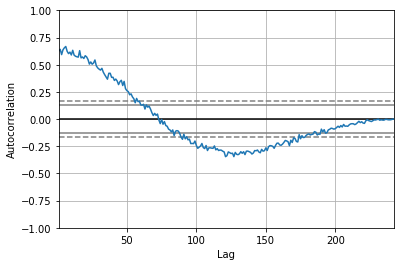

training size: 155
validation size: 38
test size: 48
plot for ARIMA model ...


/anaconda3/envs/leetcode/lib/python3.6/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/anaconda3/envs/leetcode/lib/python3.6/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
/anaconda3/envs/leetcode/lib/python3.6/site-packages/scipy/signal/signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this 

training size: 155
validation size: 38
test size: 48
RMSE: 30.567


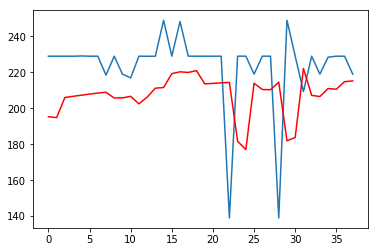

RMSE: 29.306


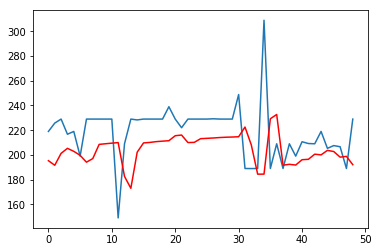

/Users/liyuan/Desktop/SI699/codes/time_feature_modeling.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  price_data['day'] = price_data['date_time'].apply(lambda x: x.day)
/Users/liyuan/Desktop/SI699/codes/time_feature_modeling.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  price_data['week'] = price_data['date_time'].apply(lambda x: x.week)
/Users/liyuan/Desktop/SI699/codes/time_feature_modeling.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexe

price data len: 242
242
variance of data: 2146
training size: 155
validation size: 38
test size: 48
training RMSE: 37.643942427158926
valiation RMSE: 83.92821961729362
test RMSE: 53.46784285103863
(38, 1)
(49, 1)
(38, 1)
(49, 1)
y_train shape: (38, 1)
y_test shape: (49, 1)
train rmse: 22
test rmse: 27
training size: 155
validation size: 38
test size: 48
training RMSE: 36.18824539994979
valiation RMSE: 67.10979163098759
test RMSE: 64.33389846094522


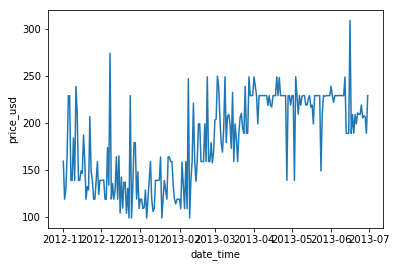

In [60]:
def get_time_prop_modeling(all_data, prop_id):
    '''combine functions from time modeling and prop modeling from separately to a single one'''
    y_pred_train_ts, y_pred_test_ts = time_modeling(all_data,prop_id)
    y_pred_train_prop, y_pred_test_prop = get_prop_modeling(all_data,prop_id)  
    return y_pred_train_ts, y_pred_test_ts, y_pred_train_prop, y_pred_test_prop

y_pred_train_ts, y_pred_test_ts, y_pred_train_prop, y_pred_test_prop = get_time_prop_modeling(all_data, 134232)

In [63]:
# rewrite into functions
def modeling_stack(y_pred_train_ts,y_pred_test_ts, y_pred_train_prop, y_pred_test_prop, model):
    '''stack modeling from property modeling and time feature modeling'''
    # reshape predictions from time modeling
    y_pred_train_ = y_pred_train_ts.reshape(-1,1)
    y_pred_test_ = y_pred_test_ts.reshape(-1,1)

    # checking
    print('y_pred_train_', y_pred_train_.shape)
    print('y_pred_test_',y_pred_test_.shape)

    # reshape predictions from propery modeling
    print('y_pred_train_prop',y_pred_train_prop.shape)
    print('y_pred_test_prop',y_pred_test_prop.shape)
    y_pred_train_prop_ = y_pred_train_prop.reshape(-1,1)
    y_pred_test_prop_ = y_pred_test_prop.reshape(-1,1)

    # combine predictions results 
    X_train = np.concatenate(( y_pred_train_prop_, y_pred_train_), axis=1)
    X_test = np.concatenate(( y_pred_test_prop_, y_pred_test_), axis=1)
    # get y_train, y_test
    y_train = tsm.val
    y_test = tsm.test

    # ---------------------------
    # task: fit third-layer model
    # ---------------------------
    # model = LinearRegression()
    # model = xgb.XGBRegressor(learning_rate = 0.1, max_depth = 5, reg_alpha = 20, n_estimators = 20) 
    # model = RandomForestRegressor()

    reg = model.fit(X_train, y_train)
    y_pred_train = reg.predict(X_train)
    y_pred_test = reg.predict(X_test)
    # get rmse
    train_RMSE = get_rmse(y_pred_train ,y_train)
    test_RMSE = get_rmse(y_pred_test ,y_test)
    print('train rmse: %d'%train_RMSE)
    print('test rmse: %d'%test_RMSE)
    return train_RMSE,test_RMSE

# specify the third-layer model of your choice
# model = RandomForestRegressor()
model = xgb.XGBRegressor(learning_rate = 0.1, max_depth = 5, reg_alpha = 20, n_estimators = 20) 
train_RMSE,test_RMSE = modeling_stack(y_pred_train_ts,y_pred_test_ts, y_pred_train_prop, y_pred_test_prop, model)

y_pred_train_ (38, 1)
y_pred_test_ (49, 1)
y_pred_train_prop (38,)
y_pred_test_prop (49,)
train rmse: 30
test rmse: 30


In [68]:
def whole_func(prop_id):
    # envoke function as a whole
    y_pred_train_ts, y_pred_test_ts, y_pred_train_prop, y_pred_test_prop = get_time_prop_modeling(all_data, prop_id)

    # specify the third-layer model of your choice
    # model = RandomForestRegressor()
    model = xgb.XGBRegressor(learning_rate = 0.1, max_depth = 5, reg_alpha = 20, n_estimators = 20) 
    train_RMSE,test_RMSE = modeling_stack(y_pred_train_ts,y_pred_test_ts, y_pred_train_prop, y_pred_test_prop, model)
    return train_RMSE,test_RMSE


property has 1635 records
property has 242 records by day


/Users/liyuan/Desktop/SI699/codes/ts_modeling_v2.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  prop_data['date_time'] = pd.to_datetime(prop_data.date_time)
/Users/liyuan/Desktop/SI699/codes/ts_modeling_v2.py:77: FutureWarning: 'pandas.tools.plotting.autocorrelation_plot' is deprecated, import 'pandas.plotting.autocorrelation_plot' instead.
  autocorrelation_plot(data)


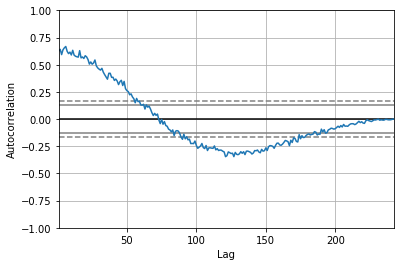

training size: 155
validation size: 38
test size: 48
plot for ARIMA model ...
training size: 155
validation size: 38
test size: 48


/anaconda3/envs/leetcode/lib/python3.6/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/anaconda3/envs/leetcode/lib/python3.6/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
/anaconda3/envs/leetcode/lib/python3.6/site-packages/scipy/signal/signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this 

RMSE: 30.567


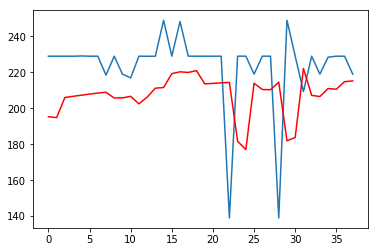

RMSE: 29.306


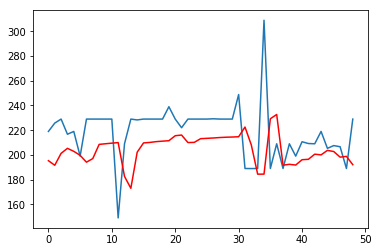

/Users/liyuan/Desktop/SI699/codes/time_feature_modeling.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  price_data['day'] = price_data['date_time'].apply(lambda x: x.day)
/Users/liyuan/Desktop/SI699/codes/time_feature_modeling.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  price_data['week'] = price_data['date_time'].apply(lambda x: x.week)
/Users/liyuan/Desktop/SI699/codes/time_feature_modeling.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexe

price data len: 242
242
variance of data: 2146
training size: 155
validation size: 38
test size: 48
training RMSE: 37.643942427158926
valiation RMSE: 83.92821961729362
test RMSE: 53.46784285103863
(38, 1)
(49, 1)
(38, 1)
(49, 1)
y_train shape: (38, 1)
y_test shape: (49, 1)
train rmse: 22
test rmse: 27
training size: 155
validation size: 38
test size: 48
training RMSE: 36.18824539994979
valiation RMSE: 67.10979163098759
test RMSE: 64.33389846094522
y_pred_train_ (38, 1)
y_pred_test_ (49, 1)
y_pred_train_prop (38,)
y_pred_test_prop (49,)
train rmse: 30
test rmse: 30


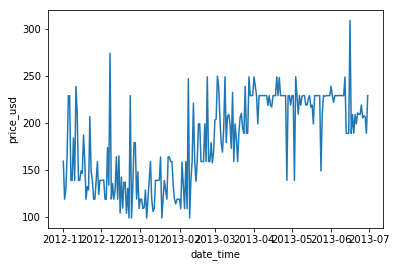

In [64]:
# envoke function as a whole
# y_pred_train_ts, y_pred_test_ts, y_pred_train_prop, y_pred_test_prop = get_time_prop_modeling(all_data, 134232)

# # specify the third-layer model of your choice
# # model = RandomForestRegressor()
# model = xgb.XGBRegressor(learning_rate = 0.1, max_depth = 5, reg_alpha = 20, n_estimators = 20) 
# train_RMSE,test_RMSE = modeling_stack(y_pred_train_ts,y_pred_test_ts, y_pred_train_prop, y_pred_test_prop, model)